In [1]:
import torch
import torch.nn as nn
# import torch.optim as optim
# import torch.nn.init as init

# 추가적인 모듈
import torchvision
from torch.utils import data # Data의 batch size 설정 및 random하게 섞기 등을 해주는 모듈
import torchsummary

import utils

In [2]:
batch_size = 32
learning_rate = 0.001
num_epoch = 100

transform = torchvision.transforms.Compose(
    torchvision.transforms.ToTensor(),  # convert image to Tensor
)

In [3]:
train_data=torchvision.datasets.CIFAR10("../DataSets/", train=True, transform=torchvision.transforms.ToTensor(), target_transform=None, download=True)
test_data=torchvision.datasets.CIFAR10("../DataSets/", train=False, transform=torchvision.transforms.ToTensor(), target_transform=None, download=True)

dataset_size = len(train_data)
train_size = int(dataset_size * 0.8)
test_size = int(batch_size)
validation_size = dataset_size - train_size - test_size

train_dataset, val_dataset, train_test = data.random_split(train_data, [train_size, validation_size, test_size])

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=6, drop_last=True)
train_test_loader = data.DataLoader(train_test, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(train_data)
print(train_data[0][0].shape)
print(train_loader)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../DataSets/
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([3, 32, 32])


In [5]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        # 점선 화살표 부분 맞춰는 코드
        # stride가 1이 아니거나(outplane이 /2로 작아지거나) or in_channel이 out_channel*expansion()
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [6]:
class ResCRNN(nn.Module):
    def __init__(self, num_block: int = [3, 3], num_classes: int = 10, init_weights: bool = True) -> None:
        super().__init__()

        self.in_channels = 64
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.conv2_x = self._make_layer(BottleNeck, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(BottleNeck, 128, num_block[1], 2)
        self.c01 = nn.Sequential(
            nn.Conv2d(128 * BottleNeck.expansion, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU()
        ) #[batch,1,8,8]

        self.rnn = nn.RNN(input_size=8, hidden_size=20, num_layers=2, batch_first=True, dropout=0.3)

        self.fc = nn.Linear(160, 1000)
        self.fc2 = nn.Linear(1000, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inplanes, out_channels, stride))
            self.inplanes = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x, hidden=torch.zeros(1, 2, 20, requires_grad=True).to(torch.device('cuda'))):#
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.c01(output) 
        # print(output.shape) # shape = [batch,1,8,8]
        output = output.view([output.shape[0], 8, 8])
        # print(output.shape)
        outputs, hidden = self.rnn(output, hidden)
        # output = torch.cat((output11, output21, output31, output41), dim=1)       
        # print(hidden.shape)
        # print(outputs.shape)
        # output = self.final_conv(output)

        outputs = torch.flatten(outputs, 1)
        # print(outputs.shape)
        outputs = self.fc(outputs)
        outputs = self.fc2(outputs)
        return outputs

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResCRNN([3, 5]).to(device)

# 모델이 잘 통과하는지 확인
x = torch.randn(32, 3, 32, 32).to(device)
hidden = torch.zeros(2, 32, 20, requires_grad=True).to(device)
output = model(x, hidden)
print(output.size())

# 모델 summary
# torchsummary.summary(model, (1, 28, 28), device=device.type)
# torchsummary.summary(model, (1, 28, 28), hidden, device=device.type)

torch.Size([32, 10])


In [8]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResCRNN([5,8]).to(device)

loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                epochs=num_epoch,
                                                max_lr=0.1,
                                                pct_start=0.3,
                                                steps_per_epoch=1
                                                )
loss_array = []
accuracy_array = []

test_model_flag = False

In [9]:
train_datas = train_test_loader if test_model_flag is True else train_loader
lrs = []
val_rnn_acc = 0
for i in range(num_epoch):
    print("epoch", i, "is start")
    for j, [img, label] in enumerate(train_datas):
        x = img.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        hidden = torch.zeros(2, batch_size, 20, requires_grad=True).to(device)
        output= model.forward(x, hidden=hidden)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if ((j == 0) if test_model_flag is True else (j % 100 == 0)):
            loss_array.append(loss.detach().cpu().numpy())
            val_rnn_acc = utils.cal_rnn_acc(model=model,
                                    datas=train_test_loader if test_model_flag is True else test_loader,
                                    device=device,
                                    hidden = torch.zeros(2, batch_size, 20, requires_grad=True).to(device))
            print('Accuracy of Test Data: {0:.3f}, loss: {1:.4f},  lr: {2:.6f}'.format(val_rnn_acc, loss_array[-1], optimizer.param_groups[0]['lr']))
            accuracy_array.append(val_rnn_acc.detach().cpu().numpy())
            if val_rnn_acc > 99.5:
                break
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    if val_rnn_acc > 99.5:
                break

epoch 0 is start
Accuracy of Test Data: 9.665, loss: 2.2991,  lr: 0.004000
Accuracy of Test Data: 10.246, loss: 2.3046,  lr: 0.004000
Accuracy of Test Data: 11.238, loss: 2.2892,  lr: 0.004000
Accuracy of Test Data: 18.199, loss: 2.0898,  lr: 0.004000
Accuracy of Test Data: 23.768, loss: 2.0012,  lr: 0.004000
Accuracy of Test Data: 24.890, loss: 1.8133,  lr: 0.004000
Accuracy of Test Data: 26.813, loss: 1.8366,  lr: 0.004000
Accuracy of Test Data: 30.429, loss: 2.3603,  lr: 0.004000
Accuracy of Test Data: 32.712, loss: 1.8833,  lr: 0.004000
Accuracy of Test Data: 34.305, loss: 2.0367,  lr: 0.004000
Accuracy of Test Data: 36.478, loss: 1.7223,  lr: 0.004000
Accuracy of Test Data: 38.211, loss: 1.8733,  lr: 0.004000
Accuracy of Test Data: 40.635, loss: 1.6432,  lr: 0.004000
epoch 1 is start
Accuracy of Test Data: 40.244, loss: 1.6245,  lr: 0.004281
Accuracy of Test Data: 41.156, loss: 1.6343,  lr: 0.004281
Accuracy of Test Data: 43.329, loss: 1.5277,  lr: 0.004281
Accuracy of Test Data: 

KeyboardInterrupt: 

/home/vision/vision_practice/Funny/utils.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


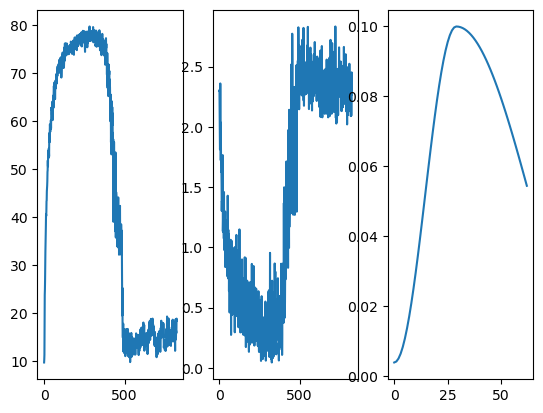

In [10]:
import utils
utils.plot_acc_loss(accuracy_array=accuracy_array, loss_array=loss_array, lrs=lrs)

In [12]:
testdata_acc = utils.cal_rnn_acc(model=model,
                                    datas= test_loader,
                                    device=device,
                                    hidden = torch.zeros(2, batch_size, 20, requires_grad=True).to(device))
print("Accuracy of Test Data: {}".format(testdata_acc))

Accuracy of Test Data: 18.038862228393555
